In [1]:
"20只船舶，1个无人机基站，5个无人机，时间300分钟"
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
from numpy import random
import math
import time
import matplotlib.pyplot as plt

In [2]:
# 输入模型参数
num_drones = 5  # 无人机数量
speed_drones = 30  # 无人机的飞行速度是30knots
max_endurance = 120  # 无人机最长续航时间（分钟）(文中的Q)
battery_replacing_time = 5  # 对无人机换电池的时间
Tmax = 300  # 总时长（分钟）
num_stations = 1  # 基站数量
station_xloc = int(random.uniform(-85, 85))  # 站点位置
station_yloc = 0  # 站点位置
num_vessels = 20  # 船只数量
speed_vessels = 5  # 假设船舶的航速是5konts(文中假设是5~10knots)
inspection_time = 5  # 对船舶的检查时间为5分钟
TmaxSet = [i for i in range(1, Tmax + 1)]

In [3]:
# 弧的生成
station_node = []
for t in range(1, Tmax + 1):
    station_node.append(('s', t))
station_node = gp.tuplelist(station_node)
weight_station = 0

weight_vessels, vessel_xloc, vessel_yloc = {}, {}, {}
for i in range(1, num_vessels + 1):
    weight_vessels[i] = random.randint(low=5, high=15)
    vessel_xloc[i] = int(random.uniform(-85, 85))
    vessel_yloc[i] = int(random.uniform(0, 20))
vessel_node = gp.tuplelist([(i, t) for i in range(1, num_vessels + 1) 
                            for t in range(1, Tmax + 1)])  # 船舶所有的点

node = []
for i in station_node:
    node.append(i)
for i in vessel_node:
    node.append(i)  # 网络中所有的点集合
node = gp.tuplelist(node)

SailingTimeSV, SailingTimeVV = {}, {}
# station和vessel之间的航行时间
for i in range(1, num_vessels + 1):
    SailingTimeSV['s', i] = round(math.sqrt(
        math.pow(station_xloc - vessel_xloc[i], 2) + math.pow(station_yloc - vessel_yloc[i], 2)) / speed_drones, 2)
# print(SailingTimeSV)
# vessel和vessel之间的航行时间
for i in range(1, num_vessels + 1):
    for j in range(1, num_vessels + 1):
        if i != j:
            SailingTimeVV[i, j] = round(math.sqrt(
                math.pow(vessel_xloc[i] - vessel_xloc[j], 2) + math.pow(vessel_yloc[i] - vessel_yloc[j],
                                                                        2)) / speed_drones, 2)
            Arc, Weight = [], {}
# station到vessel有的弧
for i in range(1, num_vessels + 1):
    for t in range(1, Tmax + 1):
        if t + SailingTimeSV['s', i] + inspection_time <= Tmax:
            Arc.append(('s', t, i, math.ceil(t + SailingTimeSV['s', i] + inspection_time)))
            Weight[('s', t, i, math.ceil(t + SailingTimeSV['s', i] + inspection_time))] = (0 + weight_vessels[
                i]) / 2

# vessel到vessel有的弧
for i in range(1, num_vessels + 1):
    for j in range(1, num_vessels + 1):
        if i != j:
            for t in range(1, Tmax + 1):
                if t + SailingTimeVV[i, j] + inspection_time <= Tmax:
                    Arc.append((i, t, j, math.ceil(t + SailingTimeVV[i, j] + inspection_time)))
                    Weight[(i, t, j, math.ceil(t + SailingTimeVV[i, j] + inspection_time))] = \
                        (weight_vessels[i] + weight_vessels[j]) / 2

# vessel到station有的弧
for i in range(1, num_vessels + 1):
    for t in range(1, Tmax + 1):
        if t + SailingTimeSV['s', i] + battery_replacing_time <= Tmax:
            Arc.append((i, t, 's', math.ceil(t + SailingTimeSV['s', i] + battery_replacing_time)))
            Weight[(i, t, 's', math.ceil(t + SailingTimeSV['s', i] + battery_replacing_time))] = \
                (0 + weight_vessels[i]) / 2
Arc = gp.tuplelist(Arc)

In [4]:
start_time=time.time()
# ----- model -----
m = gp.Model('model')
m.setParam('OutputFlag', 0)  # 表示关闭log输出信息，不观察其输出信息

# decision variable
x = m.addVars(Arc, vtype=GRB.BINARY, name='x')
y = m.addVars(TmaxSet, lb=0, ub=5, vtype=GRB.INTEGER, name='y')
q = m.addVars(node, lb=0, vtype=GRB.CONTINUOUS, name='q')
y[1].Start = num_drones
# objective
m.setObjective(sum(Weight[i] * x[i] for i in Arc), GRB.MAXIMIZE)

# constraints

for (i, t1) in station_node:
    if t1 - 1 >= 1:
        m.addConstr(sum(x[i, t1, j, t2] for (i, t1, j, t2) in Arc.select(i, t1, '*', '*')) - \
                    sum(x[j, t2, i, t1] for (j, t2, i, t1) in Arc.select('*', '*', i, t1)) == y[t1 - 1] - y[t1],
                    name='c1')

for (i, t1) in vessel_node:
    m.addConstr(sum(x[i, t1, j, t2] for (i, t1, j, t2) in Arc.select(i, t1, '*', '*')) - \
                sum(x[j, t2, i, t1] for (j, t2, i, t1) in Arc.select('*', '*', i, t1)) == 0, name='c2')

for (i, t1) in vessel_node:
    for (j, t2) in node:
        if (i, t1, j, t2) in Arc:
            m.addConstr(q[i, t1] - (t2 - t1) * x[i, t1, j, t2] + \
                        (max_endurance + battery_replacing_time) * (1 - x[i, t1, j, t2]) >= q[j, t2], name='c3')

for (i, t1) in station_node:
    for (j, t2) in vessel_node:
        if (i, t1, j, t2) in Arc:
            m.addConstr((max_endurance + battery_replacing_time) - (t2 - t1) * x[i, t1, j, t2] >= q[j, t2], name='c4')

for v in range(1, num_vessels + 1):
    m.addConstr(sum(x[i, t1, v, t2] for (i, t1, v, t2) in Arc.select('*', '*', v, '*')) <= 1, name='c5')

for (i, t1) in station_node:
    m.addConstr(sum(x[i, t1, j, t2] for (i, t1, j, t2) in Arc.select(i, t1, '*', '*')) + \
                sum(x[j, t2, i, t1] for (j, t2, i, t1) in Arc.select('*', '*', i, t1)) <= 1, name='c6')


Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-02


In [5]:
# optimize
m.optimize()
if m.status == GRB.Status.OPTIMAL:
    Obj = m.objVal
    print(f"Optimal Objective Value: {Obj}")
else:
    print("Optimal solution not found.")

# 输出最优性间隙
gap = m.MIPGap
print(f"Optimality Gap: {gap * 100:.2f}%")

# for v in m.getVars():
#     print('%s \t %g' % (v.varName, v.x))
for i in Arc:
    if x[i].x == 1:
        print('x', i, x[i].x)

#for i in TmaxSet:
    #if y[i].x > 0:
        #print('y',i,y[i].x)

#for i in node:
    #if q[i].x > 0:
        #print('q', i, q[i].x)
end_time=time.time()
print('calculate time:' ,end_time-start_time)

Optimal Objective Value: 183.0
Optimality Gap: 0.00%
x ('s', 53, 1, 60) 1.0
x ('s', 44, 3, 52) 1.0
x ('s', 6, 5, 15) 1.0
x ('s', 283, 6, 289) 1.0
x ('s', 285, 7, 291) 1.0
x ('s', 58, 8, 66) 1.0
x ('s', 61, 9, 67) 1.0
x ('s', 3, 10, 11) 1.0
x ('s', 11, 11, 19) 1.0
x ('s', 286, 12, 293) 1.0
x ('s', 41, 13, 48) 1.0
x ('s', 281, 14, 290) 1.0
x ('s', 5, 15, 12) 1.0
x ('s', 62, 16, 69) 1.0
x ('s', 284, 17, 290) 1.0
x ('s', 2, 18, 9) 1.0
x ('s', 59, 19, 67) 1.0
x (10, 11, 2, 19) 1.0
x (15, 12, 20, 20) 1.0
x (18, 9, 4, 15) 1.0
x (1, 60, 's', 67) 1.0
x (2, 19, 's', 25) 1.0
x (3, 52, 's', 60) 1.0
x (4, 15, 's', 22) 1.0
x (5, 15, 's', 24) 1.0
x (6, 289, 's', 295) 1.0
x (7, 291, 's', 297) 1.0
x (8, 66, 's', 74) 1.0
x (9, 67, 's', 73) 1.0
x (11, 19, 's', 27) 1.0
x (12, 293, 's', 300) 1.0
x (13, 48, 's', 55) 1.0
x (14, 290, 's', 299) 1.0
x (16, 69, 's', 76) 1.0
x (17, 290, 's', 296) 1.0
x (19, 67, 's', 75) 1.0
x (20, 20, 's', 26) 1.0
calculate time: 41.23669981956482


In [6]:
selected_paths = [(arc, x[arc].X) for arc in Arc if x[arc].X == 1]

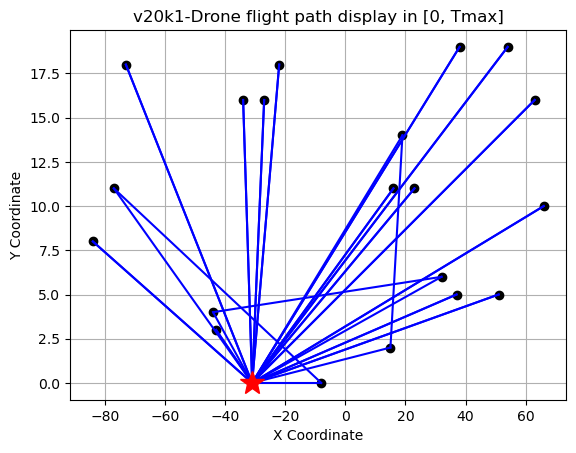

In [7]:
vessel_xloc['s'] = station_xloc
vessel_yloc['s'] = station_yloc
fig, ax = plt.subplots()
for v in vessel_xloc.keys():
    plt.plot(vessel_xloc[v], vessel_yloc[v], 'ko')

# 绘制无人机飞行轨迹，使用蓝色线段表示
for arc, value in selected_paths:
    # arc 是一个元组 (起点ID, 起飞时间, 终点ID, 降落时间)
    start_id, _, end_id, _ = arc
    start_x = vessel_xloc[start_id]
    start_y = vessel_yloc[start_id]
    end_x = vessel_xloc[end_id]
    end_y = vessel_yloc[end_id]
    # 绘制从起点到终点的线段
    plt.plot([start_x, end_x], [start_y, end_y], 'b-', label='UAV Path')
    
plt.plot(station_xloc, station_yloc, 'r*', markersize=18)

plt.title('v20k1-Drone flight path display in [0, Tmax]')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()

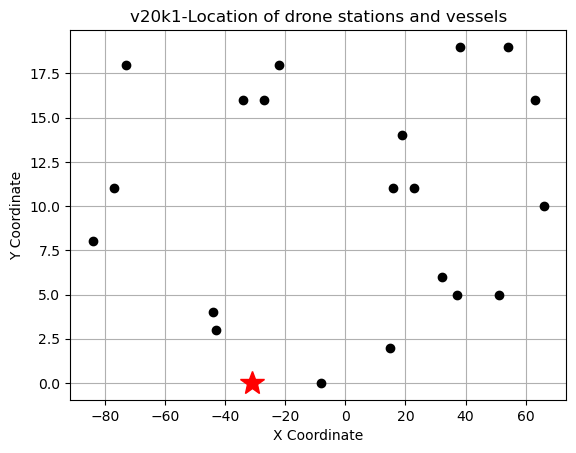

In [8]:
fig, ax = plt.subplots()
for v in vessel_xloc.keys():
    plt.plot(vessel_xloc[v], vessel_yloc[v], 'ko')
    
plt.plot(station_xloc, station_yloc, 'r*', markersize=18)

plt.title('v20k1-Location of drone stations and vessels')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()